# Week 6: RNNs and LSTMs

In [1]:
from nltk.corpus import brown
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## LSTM for sequence labelling

We are going to train an LSTM-based POS tagger.

### Model 

First let's define the model. I have already included the relevant layers. You must now fill in the missing part of the forward function which defines the relation between each layer. Refer to the class slides on LSTMs and remember that we are using this RNN for sequence labelling.

In [2]:
class LSTMSeqLabeller(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim):
        super(LSTMSeqLabeller, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.embeddings = nn.Embedding(self.vocab_size, self.emb_dim, padding_idx=0)
        self.lstm = nn.LSTMCell(self.emb_dim, self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input):
        # input is of size (batch, time_steps)
        batch_size = input.size()[0]
        time_steps = input.size()[1]
        #our initial h_(i-1) and c_(i-1) vectors are dummies
        h_prior = torch.zeros(batch_size, self.hidden_dim)
        c_prior = torch.zeros(batch_size, self.hidden_dim)
        #outputs should become a list of |time_steps| tensors of size (batch, output_dim)
        outputs = []
        input_t = torch.transpose(input, 0, 1)
        for i in range(time_steps):
            ## TO DO
            x_i = self.embeddings(input_t[i])
            h_i, c_i = self.lstm(x_i, (h_prior, c_prior))
            y_i = self.linear(h_i)
            outputs.append(y_i)
            h_prior, c_prior = h_i, c_i
            ##
        # we must now turn our list of tensors for each state back into a single tensor of size (batch, output_size, time_step)
        # This is because our loss criterion will expect model logits of (Batch_size x num_classes x any other dimensions...)
        output = torch.reshape(torch.stack(outputs, dim=0), (batch_size, self.output_dim, time_steps))
        return output 

### Data

Next we need to prepare our data for our Dataset and DataLoader. Here is the brown corpus split into sentences where each word is tagged with a POS tag

In [3]:
tagged_sents = brown.tagged_sents(categories='fiction')
#tagged_sents = brown.tagged_sents()

In [4]:
len(tagged_sents)

4249

In [5]:
tagged_sents[1]

[('Scotty', 'NP'),
 ('did', 'DOD'),
 ('not', '*'),
 ('go', 'VB'),
 ('back', 'RB'),
 ('to', 'IN'),
 ('school', 'NN'),
 ('.', '.')]

We are going to limit our vocabulary size to the 10,000 most frequent words and replace all other words by '\<UNK>'. We will also have a special '\<PAD>' token. '\<PAD>' will be our index 0 vocabulary item, and '\<UNK>' our index 1. All real tokens will then follow. So our final vocabulary of unique tokens, or types, should have length vocab_size + 2, here 10002. Let's now write a function that will return the unique vocabulary of tokens in a dataset of tagged sentences, as well as its corresponding list of unique possible POS tags.

In [6]:
def create_vocab_taglist(tagged_sents, vocab_size = 2000, unk = '<UNK>', pad = '<PAD>'):
    vocabulary = [pad, unk]
    tag_list = [pad, unk]
    ## TO DO
    counts = Counter([token for sent in tagged_sents for token,tag in sent])
    vocab = [token for token, count in counts.most_common(vocab_size)]
    vocabulary = vocabulary + vocab
    tags = []
    for sent in tagged_sents:
        for token,tag in sent:
            if token in vocabulary:
                tags.append(tag)
    tag_list = tag_list + list(set(tags))
    ##
    return vocabulary, tag_list

In [7]:
vocabulary, tag_list = create_vocab_taglist(tagged_sents)

In [8]:
len(vocabulary)

2002

In [9]:
len(tag_list)

134

Now we can define our custom dataset class. You will need to fill in the get_indexed_tagged_sents method that will populate the datasets indexed_tagged_sents property. This should be a list of sentences, where each sentence is a list of (token_idx, tag_idx) pairs.

In [10]:
class TagSentDataset(Dataset):
    def __init__(self, tagged_sents, vocabulary, tag_list):
        self.tagged_sents = tagged_sents
        self.vocabulary = vocabulary
        self.tag_list = tag_list
        self.tokens_to_idx = {k:v for v, k in enumerate(vocabulary)}
        self.idx_to_tokens = {k:v for k, v in enumerate(vocabulary)}
        self.indexed_tagged_sents = []
        self.get_indexed_tagged_sents()

    def __getitem__(self, idx):

        sent = self.indexed_tagged_sents[idx]
        inputs, labels = list(zip(*sent))
        return torch.tensor(inputs, dtype=torch.long), torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.indexed_tagged_sents)

    def get_indexed_tagged_sents(self):
        ## TO DO
        for sent in self.tagged_sents:
            indexed_sent = []
            for token, tag in sent:
                token_idx =  self.tokens_to_idx[token] if token in self.tokens_to_idx else 1
                tag_idx = self.tag_list.index(tag) if token_idx != 1 else 1
                indexed_sent.append((token_idx,tag_idx))
            self.indexed_tagged_sents.append(indexed_sent)
        ##

In [11]:
data = TagSentDataset(tagged_sents, vocabulary, tag_list)

In [12]:
len(data)

4249

Before we initialize our dataloader, we will need to write a custom collate function. The collate function can be passed to the dataloader as a parameter. This function serves the purpose of standardizing all the items in a batch. Because each of our items is a sentence and that sentences can be of different length, we need to standardize the length of all sentences in a batch so that they may then be stacked into a single tensor. We will do this by adding '\<PAD>' tokens to the beginning of sentences up to the length of the longest sentence in the batch. 

In [13]:
def collate_fn(items):
    inputs, labels = list(zip(*items))
    max_len = max([len(sent) for sent in inputs])
    batched_inputs = []
    batched_labels = []
    for sent, tags in zip(inputs, labels):
        n_pads = max_len - len(sent)
        pads = torch.zeros(n_pads, dtype=torch.long)
        pad_sent = torch.cat((pads, sent))
        pad_tags = torch.cat((pads, tags))
        batched_inputs.append(pad_sent)
        batched_labels.append(pad_tags)
    batched_inputs = torch.stack(batched_inputs)
    batched_labels = torch.stack(batched_labels)

    return batched_inputs, batched_labels     

In [14]:
dataloader = DataLoader(data, batch_size = 32, collate_fn=collate_fn, shuffle=True)

### Train loop

In [15]:
# Model Hyperparameters
vocab_size = len(data.vocabulary)
emb_dim = 100
hidden_dim = 50
output_dim = len(data.tag_list)

# Training Hyperparameters
epochs = 10
lr = 0.001

In [16]:
model = LSTMSeqLabeller(vocab_size, emb_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [17]:
loss_data = []
step = 1
model.train()
for epoch in range(epochs):
    for inputs, labels in dataloader:
        # clear gradients from optimizer
        optimizer.zero_grad()
        # get logits from model
        logits = model(inputs)
        # calculate the loss
        loss = criterion(logits, labels)
        # keep track of loss so we can plot it after
        loss_data.append((step, loss.item()))
        step+=1
        # calculate the gradients
        loss.backward()
        # add the gradients to model parameters based on learning rate
        optimizer.step()

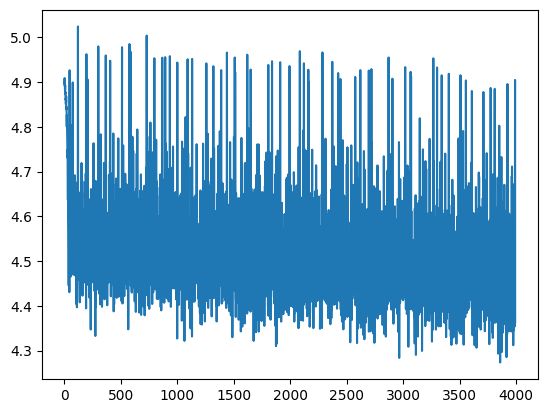

In [18]:
plt.plot(*zip(*loss_data))
plt.show()

In [19]:
def prep_sentence(sent, data):
    tokens = sent.split(" ")
    indexed_sent = []
    for t in tokens :
        idx = data.tokens_to_idx[t] if t in data.tokens_to_idx else 1
        indexed_sent.append(idx)
    return torch.tensor([indexed_sent], dtype=torch.long)    

def model_predict(x, model, data):
    model.eval()
    logits = model(x)
    y_hat = F.softmax(logits, dim=1)
    _, preds = torch.max(y_hat, dim=1)
    return preds

def retrieve_sequence(pred, data):
    sequence = []
    for idx in pred:
        sequence.append(data.tag_list[idx])
    return sequence
    

In [20]:
x = prep_sentence('There was a child .', data)

In [21]:
preds = model_predict(x, model, data)

In [22]:
retrieve_sequence(preds[0], data)

['RB+BEZ', 'JJR', 'RB+BEZ', 'JJR', 'BED']